In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1  # Bessel function

### f2 = 150  # en mm, lentille extérieure
na = 0.4  # aperture

lamb = 405  # en nm, laser bleu
M_theo = 20
pixel_size = 3.45  # en um, x et y
cam_width = 1440
cam_height = 1080

poisson_lamb = 400

M = (150 * M_theo) / 160

pxl = pixel_size / M  # en um

In [3]:
def psf(xx, yy, particle_pos, na, lamb, effective_pixel_size):
    # s'assurer que tout est en um
    px, py = particle_pos
    x_um = (xx - px) * effective_pixel_size
    y_um = (yy - py) * effective_pixel_size
    r = np.sqrt(x_um**2 + y_um**2)  # Distance en um

    # Wave vector
    k = 2 * np.pi * na / (lamb)  # Wavelength en um

    # Airy disk
    psf = np.zeros_like(r)
    nonzero_indices = r > 0
    psf[nonzero_indices] = ((2 * j1(k * r[nonzero_indices]) / (k * r[nonzero_indices])) ** 2)
    psf[r == 0] = 1  # traitement de la singularite

    return psf

In [4]:
pixel_size = 3.45  # en um, x et y
cam_width = 1440
cam_height = 1080

# Paramètres de la simulation
f2 = 150  # Facteur de l'objectif
na = 0.4  # Numerical aperture
lamb = 0.405  # Wavelength in um
M_theo = 20  # Magnification of the objective
poisson_lamb = 400  # Average number of photons
mean_photon_count = 5  # Mean number of photons emitted

In [5]:
x = np.arange(cam_width)
y = np.arange(cam_height)
X, Y = np.meshgrid(x, y)

mean_photon_count = 5  # Average photons per pixel
intensity_grid = np.random.poisson(mean_photon_count, (cam_height, cam_width))

In [6]:
# Number of points to select
num_points = 15

# Randomly select indices
random_x = np.random.choice(x, num_points)
random_y = np.random.choice(y, num_points)

# Combine into coordinates
random_points = np.column_stack((random_x, random_y))

In [7]:
for i, value in enumerate(random_points):
    particle_loc = value
    psf_values = psf(X, Y, particle_loc, na, lamb, pxl)
    
    # somme des probas à 1
    psf_values /= psf_values.sum()
    psf_flat = psf_values.flatten()
    
    # Simulate photon count based on Poisson distribution
    num_simulations = np.random.poisson(poisson_lamb)
    for _ in range(num_simulations):
        index = np.random.choice(len(psf_flat), p=psf_flat)
        
        random_x = X.flatten()[index]
        random_y = Y.flatten()[index]
        
        # Find the nearest grid indices
        grid_x_idx = np.argmin(np.abs(x - random_x))
        grid_y_idx = np.argmin(np.abs(y - random_y))
        
        # Count photon emission
        intensity_grid[grid_y_idx, grid_x_idx] += 1

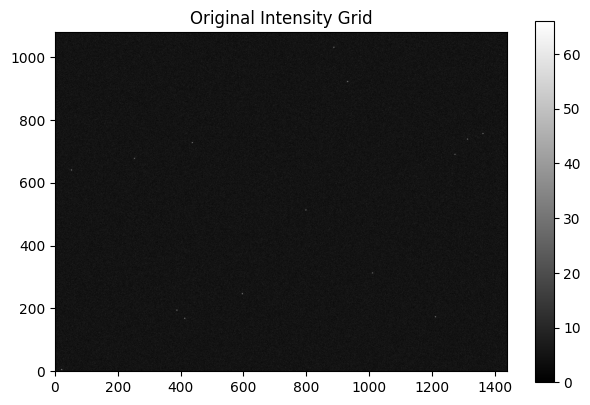

In [8]:
plt.figure(figsize=(12, 4))

# Original intensity grid with a cross at the mean of the Gaussian (from the fit)
plt.subplot(1, 2, 1)
plt.imshow(intensity_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')

In [11]:
from PIL import Image

data = intensity_grid

normalized_data = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

# Save as TIFF
Image.fromarray(normalized_data).save("microscope_image.tiff")